<a href="https://colab.research.google.com/github/Likhita111/Glaucoma_Detection/blob/main/Detecting_Glaucoma_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')
glaucoma_detection_path = kagglehub.dataset_download('sshikamaru/glaucoma-detection')

print('Data source import complete.')

Data source import complete.


# **Introduction**

**This notebook dives into creating a machine learning model to diagnose glaucoma.**


***There has not been any solid dataset for glaucoma so I made one and created a model. Please check out my dataset if you are interested.***

![](https://www.reviewofoptometry.com/CMSImagesContent/2019/10/GlaucDiff1.jpg)

# **Organizing Data**

I took the data from the sources, and seperated them into train and validation folders. Then from those folders, I sorted them into positive and negative cases. You can check out my jupyter notebook linked at the end.

In [ ]:
ls {glaucoma_detection_path}

ACRIMA/  Fundus_Train_Val_Data/  glaucoma.csv  ORIGA/


In [ ]:
import pandas as pd
train_label = pd.read_csv(glaucoma_detection_path+'/glaucoma.csv')
y_train = train_label['Glaucoma']
train_label.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


# **Looking at the Data**

I first tried some manual data augmentation and preprocessing.

In [ ]:
from numpy import asarray

from PIL import Image
# load the image
image = Image.open(glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/613.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
pixels = asarray(image)

JPEG
RGB
(3072, 2048)


In [ ]:

# global centering

# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean
# confirm it had the desired effect
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)


# example of pixel normalization
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
mean = pixels.mean()
print('pixel mean = ', mean)

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Mean: 73.460
Min: 0.000, Max: 255.000
Mean: -0.000
Min: -73.460, Max: 181.540
[[[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 [[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 [[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 ...

 [[-73.46045897 -73.46045897 -73.46045897]
  [-73.46045897 -73.46045897 -73.46045897]
  [-73.46045897 -73.46045897 -73

**Visulization**

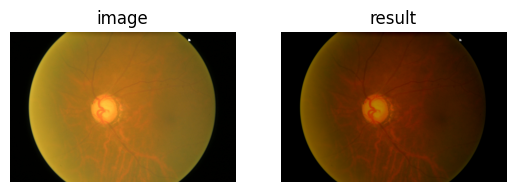

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show()

In [ ]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

# **Augmentation**

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# **Modeling**

In [ ]:
TRAIN_DIR = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'

TEST_DIR = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

In [ ]:
# prompt: EfficientNetB7 for this

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = 224, 224  # Adjust based on EfficientNetB7 requirements
batch_size = 32

# Create data generators with augmentation (adjust parameters as needed)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Assuming binary classification (Glaucoma/No Glaucoma)
)

validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load pre-trained EfficientNetB7 model (excluding top classification layer)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Adjust number of units as needed
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers (optional, but often helps initially)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Adjust number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Fine-tune the model (optional, unfreeze some base model layers)
# ... (Code for fine-tuning would go here)


Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.6455 - loss: 0.5935 - val_accuracy: 0.7031 - val_loss: 0.5646
Epoch 2/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.6250 - loss: 0.6111

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.6250 - loss: 0.6111 - val_accuracy: 0.6953 - val_loss: 0.5757
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7889 - loss: 0.4931 - val_accuracy: 0.6719 - val_loss: 0.5812
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.6562 - loss: 0.6741 - val_accuracy: 0.6953 - val_loss: 0.5689
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7607 - loss: 0.5013 - val_accuracy: 0.6875 - val_loss: 0.5641
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.6875 - loss: 0.5594 - val_accuracy: 0.6641 - val_loss: 0.5810
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7501 - loss: 0.5111 - val_accuracy: 0.6953 - val_loss: 0.5669
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.8125 - loss: 0.5020 - val_accuracy: 0.6953 - val_loss: 0.5807
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8163 - loss: 0.4401 - val_accuracy: 0.6797 - val_loss: 0.

In [ ]:
# prompt: save the model

model.save('glaucoma_detection_model.h5')


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import os
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = load_model('/content/glaucoma_detection_model.h5')  # Replace with your model file

# Define image dimensions
img_width, img_height = 224, 224

positive_test_dir = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive'
negative_test_dir = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative'


# # Test directories
# positive_test_dir = "path_to_positive_images"  # Update with actual path
# negative_test_dir = "path_to_negative_images"  # Update with actual path

# Function to predict on an image
def predict_image(img):
    img = img.resize((img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return "Glaucoma Positive" if preds[0][0] > 0.5 else "Glaucoma Negative"

# Function to test 10 positive and 10 negative images
def batch_test():
    results = []
    for label, directory in [("Positive", positive_test_dir), ("Negative", negative_test_dir)]:
        for i, filename in enumerate(os.listdir(directory)[:10]):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(directory, filename)
                prediction = predict_image(image.load_img(image_path))
                results.append(f"{filename}\t{label}\t{prediction}")
    return "\n".join(results)

# Gradio UI
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(),
    title="Glaucoma Detection",
    description="Upload a fundus image to predict glaucoma status."
)

batch_test_btn = gr.Interface(
    fn=batch_test,
    inputs=[],
    outputs=gr.Textbox(),
    title="Batch Test",
    description="Test on 10 positive and 10 negative images."
)

gr.TabbedInterface([iface, batch_test_btn], ["Single Image Prediction", "Batch Testing"]).launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d195190bccf40e08b9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://d195190bccf40e08b9.gradio.live


In [ ]:
ls {glaucoma_detection_path}

ACRIMA/  Fundus_Train_Val_Data/  glaucoma.csv  ORIGA/


In [ ]:
# prompt: download the above tested images 10 each from positive and negative as  a zip

import os
import zipfile

def create_zip_archive(positive_dir, negative_dir, output_zip_filename):
    with zipfile.ZipFile(output_zip_filename, 'w') as zipf:
        for label, directory in [('Positive', positive_dir), ('Negative', negative_dir)]:
            for i, filename in enumerate(os.listdir(directory)[:10]):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(directory, filename)
                    zipf.write(image_path, arcname=f"{label}/{filename}")


# Assuming positive_test_dir and negative_test_dir are defined as in your provided code.
positive_test_dir = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive'
negative_test_dir = glaucoma_detection_path+'/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative'


output_zip_filename = "glaucoma_images.zip"
create_zip_archive(positive_test_dir, negative_test_dir, output_zip_filename)

from google.colab import files
files.download(output_zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from PIL import Image

# Load the trained model
model = load_model("your_model.h5")  # Replace with your model's path
img_width, img_height = 224, 224  # Adjust as per your model

def predict_image_gradio(image):
    img = image.convert('RGB')  # Convert to RGB
    img = img.resize((img_width, img_height))  # Resize the image
    x = img_to_array(img)  # Convert to NumPy array
    x = np.expand_dims(x, axis=0)  # Expand dimensions for batch processing
    x = preprocess_input(x)  # Preprocess input for the model
    preds = model.predict(x)  # Get predictions
    return float(preds[0][0])  # Convert NumPy array output to float

iface = gr.Interface(
    fn=predict_image_gradio,
    inputs=gr.Image(type="pil"),
    outputs="number",
    title="Glaucoma Detection",
    description="Upload a fundus image to predict the likelihood of glaucoma."
)

iface.launch(debug=True)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'your_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# **ConvNet**

In [ ]:
'''import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator



model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))



train_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255
)

train_batches = train_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train',
    target_size=(256, 256),
    class_mode='binary'
)

validation_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255
)

validation_batches = validation_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/validation',
    target_size=(256, 256),
    class_mode='binary'
)

model = create_model()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Starts training the model
model.fit_generator(train_batches,
                    epochs=15,
                    verbose=1,
                    steps_per_epoch=len(train_batches),
                    validation_data=validation_batches,
                    initial_epoch=0,
                    validation_steps=len(validation_batches)
                    )

test_generator = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255
)

test_batches = test_generator.flow_from_directory(
    batch_size=1,
    directory='./dataset/test',
    target_size=[256, 256],
    class_mode='binary'
)

score = model.evaluate_generator(test_batches, verbose=1)

print(model.metrics_names)
print('test dataset: ' + str(score))'''

'import os\nimport tensorflow as tf\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten\nfrom keras.preprocessing.image import ImageDataGenerator\n\n\n\nmodel = Sequential()\nmodel.add(Conv2D(32, (3, 3), padding=\'same\', activation=\'relu\', input_shape=(256, 256, 3)))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(128, activation=\'relu\'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation=\'softmax\'))\n\n\n\ntrain_generator = ImageDataGenerator(\n  data_format="channels_last",\n  rescale = 1. / 255\n)\n\ntrain_batches = train_generator.flow_from_directory(\n    batch_size=32,\n    directory=\'./dataset/train\',\n    target_size=(256, 256),\n    class_mode=\'binary\'\n)\n\nvalidation_generator = ImageDataGenerator(\n  data_format="channels_last",\n  rescale = 1. / 255\n)\n\nvalidation_batches = validation_generator.flow_from_directory(\n    batch_size=32,\n  

# **ResNet50**

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 10
BATCH_SIZE = 8

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model

base_model_1 = ResNet50(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)




resnet50_model = build_model(base_model_1,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

adam = Adam(learning_rate = 0.00001)
resnet50_model.compile(adam, loss="binary_crossentropy", metrics=["accuracy"])

filepath = "./checkpoints" + "RestNet50" + "_model_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

print(train_generator.class_indices)

resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
1024
512
256
{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 306, 306, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 75, 75, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 75, 75, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 75, 75, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 233,960,578 (892.49 MB)

 Trainable params: 210,372,866 (802.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# history = resnet50_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100,
#                                        shuffle = True, validation_data = test_generator)

history = resnet50_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=10,
    shuffle=True,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4534 - loss: 1.7340 - val_accuracy: 0.7385 - val_loss: 0.9690
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5860 - loss: 1.5070 - val_accuracy: 0.7385 - val_loss: 1.1873
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6318 - loss: 1.5551 - val_accuracy: 0.7385 - val_loss: 1.0213
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6580 - loss: 1.3861 - val_accuracy: 0.7385 - val_loss: 0.9644
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7632 - loss: 1.0228 - val_accuracy: 0.7385 - val_loss: 0.8935
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 776ms/step - accuracy: 0.5919 - loss: 1.5640 - val_accuracy: 0.7385 - val_loss: 0.7517
Epoch 7/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5383 - loss: 1.4356

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 845ms/step - accuracy: 0.5317 - loss: 1.4316 - val_accuracy: 0.7385 - val_loss: 0.7046
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7255 - loss: 0.8307 - val_accuracy: 0.7385 - val_loss: 0.7603
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6413 - loss: 1.2473 - val_accuracy: 0.7385 - val_loss: 0.9102
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5869 - loss: 1.4709 - val_accuracy: 0.7385 - val_loss: 0.8707


<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


8
[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


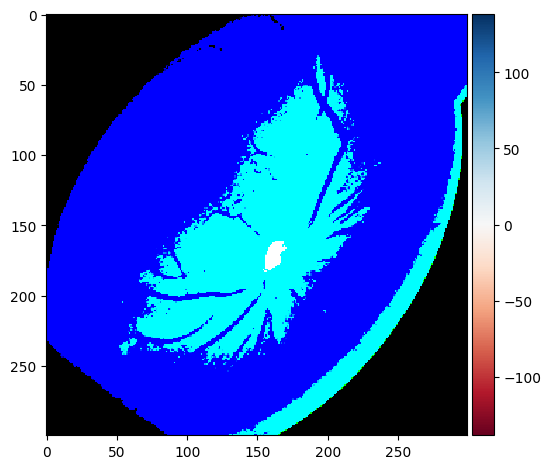

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


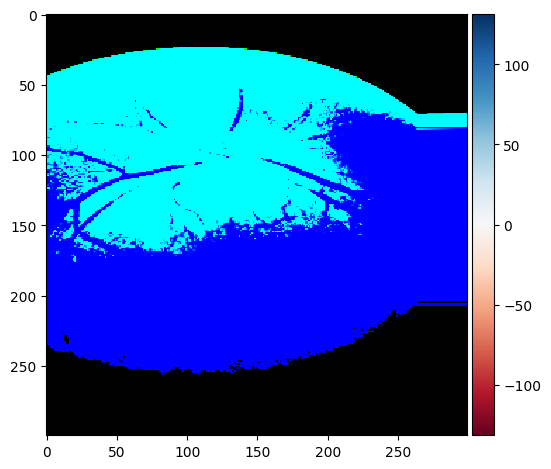

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


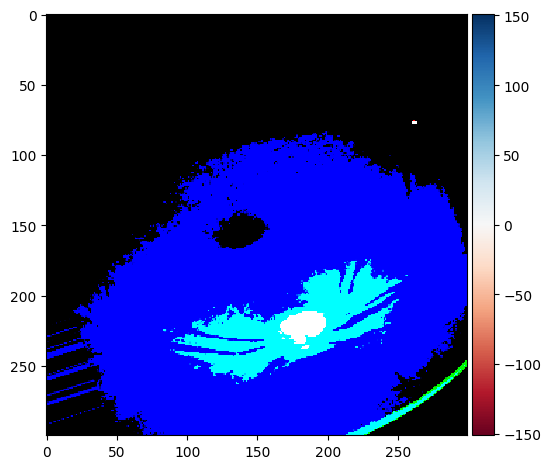

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


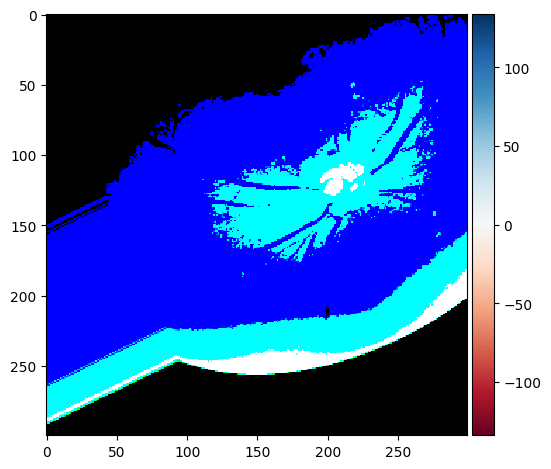

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


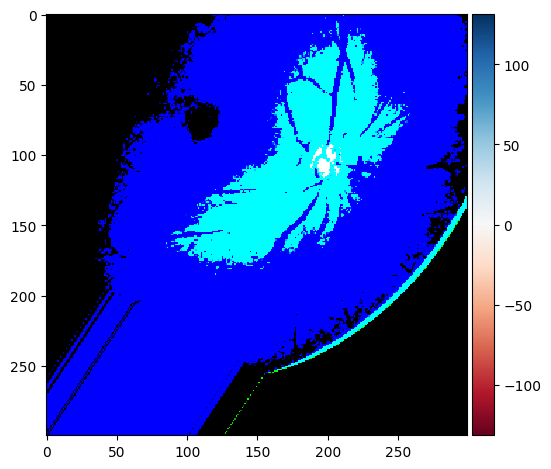

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[0. 1.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


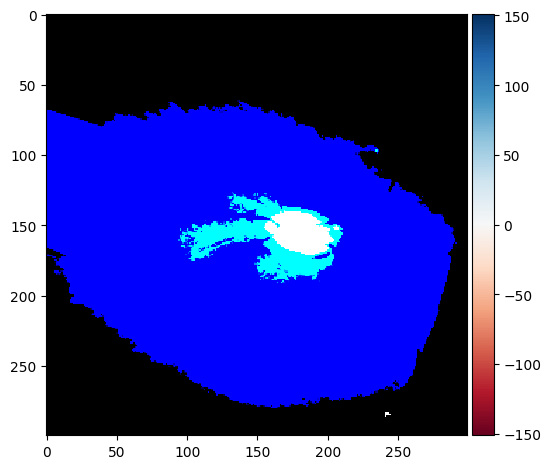

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


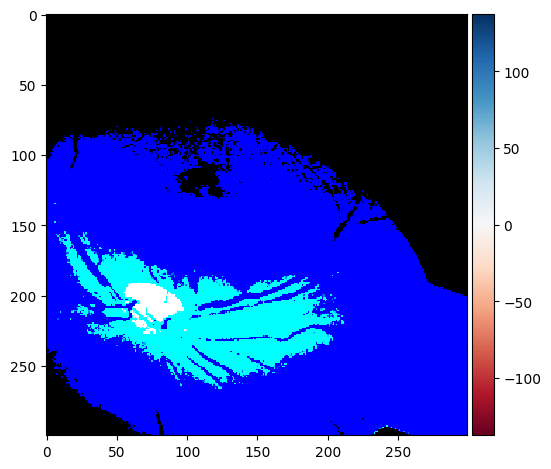

<ipython-input-7-866dcbe6a3a6>:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_RGB)


[1. 0.]


<ipython-input-7-866dcbe6a3a6>:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


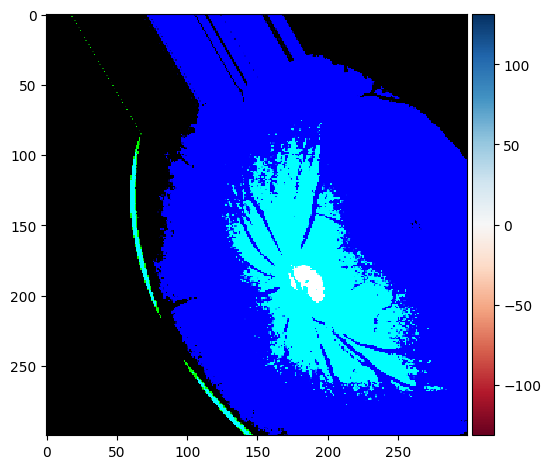

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Use __next__() instead of .next()
image_batch, label_batch = train_generator.__next__()

print(len(image_batch))
for i in range(0, len(image_batch)):
    image = image_batch[i]
    print(label_batch[i])
    imshow(image)

# **Inception V3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
base_model_2 = InceptionV3(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

NameError: name 'HEIGHT' is not defined

In [ ]:
inception_model = build_model(base_model_2,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))
inception_model.compile(optimizer = RMSprop(learning_rate = 0.001), loss="binary_crossentropy", metrics=["accuracy"])
inception_model.summary()

1024
512
256


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 156,678,178 (597.68 MB)

 Trainable params: 134,875,394 (514.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# history_2 = inception_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100,
#                                        shuffle = True, validation_data = test_generator)

history_2 = inception_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=20,  # Or adjust as needed
    shuffle=True,
    validation_data=test_generator
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 857ms/step - accuracy: 0.6647 - loss: 547.9685 - val_accuracy: 0.7462 - val_loss: 83.6000
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 837ms/step - accuracy: 0.5654 - loss: 588.0533 - val_accuracy: 0.5000 - val_loss: 58.4274
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 800ms/step - accuracy: 0.5604 - loss: 384.1615 - val_accuracy: 0.7385 - val_loss: 152.7532
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.6427 - loss: 432.6168 - val_accuracy: 0.7385 - val_loss: 66.4344
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 838ms/step - accuracy: 0.7539 - loss: 259.1677 - val_accuracy: 0.7385 - val_loss: 102.0935
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 845ms/step - accuracy: 0.7410 - loss: 208.3065 - val_accuracy: 0.6923 - val_loss: 29.7263
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 792ms/step - accuracy: 0.6309 - loss: 209.8972 - val_accuracy: 0.6538 - val_loss: 23.7956
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.6744 - lo

In [ ]:
# prompt: like the above i want two other models vgg16 and efficientnet

from tensorflow.keras.applications import VGG16, EfficientNetB0



# VGG16 Model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
vgg16_model = build_model(base_model_vgg16, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))
vgg16_model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])
vgg16_model.summary()
history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=10,
    shuffle=True,
    validation_data=test_generator
)


# EfficientNetB0 Model
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
efficientnet_model = build_model(base_model_efficientnet, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))
efficientnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])
efficientnet_model.summary()
history_efficientnet = efficientnet_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=10,
    shuffle=True,
    validation_data=test_generator
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1024
512
256


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 300, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 150, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │      42,468,352 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 57,839,682 (220.64 MB)

 Trainable params: 43,124,994 (164.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6455 - loss: 4.1082 - val_accuracy: 0.7308 - val_loss: 1.3462
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5901 - loss: 4.9535 - val_accuracy: 0.7385 - val_loss: 1.3438
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6797 - loss: 2.7778 - val_accuracy: 0.7308 - val_loss: 1.4189
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6409 - loss: 3.9148 - val_accuracy: 0.7385 - val_loss: 1.4297
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7067 - loss: 3.2903 - val_accuracy: 0.7385 - val_loss: 1.5493
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 976ms/step - accuracy: 0.7136 - loss: 3.5065 - val_accuracy: 0.7385 - val_loss: 1.3525
Epoch 7/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6083 - loss: 5.0929

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6167 - loss: 4.6870 - val_accuracy: 0.7308 - val_loss: 1.2083
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7450 - loss: 3.0029 - val_accuracy: 0.7308 - val_loss: 1.2432
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6664 - loss: 3.2226 - val_accuracy: 0.7308 - val_loss: 1.2081
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6359 - loss: 3.2281 - val_accuracy: 0.7385 - val_loss: 1.0358
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1024
512
256


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 135,779,237 (517.96 MB)

 Trainable params: 131,729,666 (502.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7563 - loss: 0.6093 - val_accuracy: 0.7385 - val_loss: 0.6731
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7429 - loss: 0.8177 - val_accuracy: 0.7385 - val_loss: 0.6521
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7217 - loss: 0.8111 - val_accuracy: 0.7385 - val_loss: 0.5814
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7520 - loss: 0.6474 - val_accuracy: 0.7385 - val_loss: 0.5897
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6593 - loss: 0.8761 - val_accuracy: 0.7385 - val_loss: 0.5649
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.7747 - loss: 0.6612 - val_accuracy: 0.7385 - val_loss: 0.5802
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - accuracy: 0.7194 - loss: 0.7539 - val_accuracy: 0.7385 - val_loss: 0.5856
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7117 - loss: 0.6970 - val_accuracy: 0.7385 - val_l

In [ ]:
# : save the 2 models to gdrive

from google.colab import drive
drive.mount('/content/drive')

resnet50_model.save('/content/drive/My Drive/glaucoma_resnet50_model.h5')
inception_model.save('/content/drive/My Drive/glaucoma_inception_model.h5')
vgg16_model.save('/content/drive/My Drive/vgg16_model.h5')
efficientnet_model.save('/content/drive/My Drive/efficientnet_model.h5')


ValueError: mount failed

In [ ]:
# : save the 2 models to gdrive




vgg16_model.save('vgg16_model.h5')
efficientnet_model.save('efficientnet_model.h5')


NameError: name 'vgg16_model' is not defined

In [ ]:
# prompt: save the models

# Assuming you have already defined resnet50_model and inception_model
# and mounted your Google Drive as shown in the original code.


# Save the models to Google Drive
resnet50_model.save('/content/glaucoma_resnet50_model.h5')
inception_model.save('/content/glaucoma_inception_model.h5')


NameError: name 'resnet50_model' is not defined

In [ ]:
# : download the models to local pc

from google.colab import files

files.download('/content/glaucoma_resnet50_model.h5')
files.download('/content/glaucoma_inception_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: test on 10 images positive and 10 images negative with efficientnet87 model, show filename, actual, predicted values

import os
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = load_model('glaucoma_detection_model_efficientnet87.h5')  # Replace with your model file

# Define image dimensions
img_width, img_height = 224, 224

# Test directories
positive_test_dir = os.path.join(glaucoma_detection_path, 'Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive')
negative_test_dir = os.path.join(glaucoma_detection_path, 'Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative')

# Function to predict on an image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0][0]  # Assuming binary classification output

# Test on 10 positive and 10 negative images
print("Filename\tActual\tPredicted")
for label, directory in [('Positive', positive_test_dir), ('Negative', negative_test_dir)]:
  for i, filename in enumerate(os.listdir(directory)[:10]):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
      image_path = os.path.join(directory, filename)
      prediction = predict_image(image_path)
      print(f"{directory}\t{filename}\t{label}\t{prediction}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'glaucoma_detection_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
# : gradio userinterface to predict using both models one after another

import gradio as gr
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np

# Load your models
# resnet50_model = keras.models.load_model('/content/glaucoma_resnet50_model.h5')
# inception_model = keras.models.load_model('/content/drive/MyDrive/glaucoma_inception_model (2).h5')
# vgg16_model = keras.models.load_model('/content/vgg16_model.h5')
# efficientnet_model = keras.models.load_model('/content/efficientnet_model.h5')

EfficientNetB7_model = keras.models.load_model('/content/glaucoma_detection_model.h5')


def predict_image(image):
    # Preprocess the image for both models (adjust as needed)
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    image = image.resize((224, 224)) # Resize to match model input
    image_array = np.array(image) / 255.0  # Normalize
    image_array = np.expand_dims(image_array, axis=0)


    # ResNet50 prediction
    # resnet_prediction = resnet50_model.predict(image_array)
    # resnet_class = np.argmax(resnet_prediction)

    # InceptionV3 prediction
    e87prediction = EfficientNetB7_model.predict(image_array)
    e87class = np.argmax(e87prediction)

    # vgg16_prediction = vgg16_model.predict(image_array)
    # vgg16_class = np.argmax(vgg16_prediction)

    # efficientnet_prediction = efficientnet_model.predict(image_array)
    # efficientnet_class = np.argmax(efficientnet_prediction)


    return f"InceptionV3 Prediction: {e87class}  "


iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Glaucoma Prediction",
    description="Upload an image to get predictions from two models."
)

iface.launch(debug = True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8f0cfba0f1307fc681.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://8f0cfba0f1307fc681.gradio.live


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: gradio with efficient net 87 model . input is image file name
# preprocess code  is
# # Function to predict on an image
# def predict_image(image_path):
#     img = image.load_img(image_path, target_size=(img_width, img_height))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     preds = model.predict(x)
#     return preds[0][0]  # Assuming binary classification output

import gradio as gr
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Load the trained model
model = load_model('glaucoma_detection_model.h5')  # Replace with your model file

# Define image dimensions
img_width, img_height = 224, 224

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0][0]  # Assuming binary classification output

EfficientNetB7_model = load_model('/content/glaucoma_detection_model.h5')

def predict_image_gradio(image):
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    e87prediction = EfficientNetB7_model.predict(image_array)
    e87class = np.argmax(e87prediction)

    return f"EfficientNetB7 Prediction: {e87class}"

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Glaucoma Prediction",
    description="Upload an image to get a prediction."
)

iface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7670699b455dccfb76.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2103, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1650, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
           ^^^^^^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://bb9854ce12ecd512b3.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://7670699b455dccfb76.gradio.live
